# Task 1 Result Analysis

This notebook contains the main data analysis of the models' results. It includes tables and figures to understand the differences in performances of all models and compute the mean across folds.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


# Navigate up two levels to reach the grandparent directory (CL Control)
parent_dir = os.path.abspath(os.path.join('..',))
sys.path.append(parent_dir)

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
name = 'Chewie'
date = '1007'
fold = 0
target_variable = 'vel'

In [5]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [6]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [7]:
data_path = '../Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [8]:
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

In [9]:
baseline_df.id.nunique()

170

In [10]:
force_df =  tidy_df.loc[tidy_df['epoch'] == 'AD']

We need to consider only the trials for which the monkey has already adapted to the perturbation.

In [11]:
ids_to_keep = force_df.id.unique()[50:]

The baseline subset has a total of 170 trials, whereas the perturbation one contains 201 trials, we can for now try to remove the first 50 trials from the perturbation subset.

In [12]:
force_df = force_df.loc[force_df.id.isin(ids_to_keep)]

## Loading models

In [13]:
path_to_models = '../Models/Models_Force'

In [14]:
subsets = [baseline_df, force_df, tidy_df]
subsets_str = ['Baseline', 'Adaptation', 'All'] 

In [15]:
models = []
folds = []
EV = []
R2 = []
y_pred = []
y_true = []
data = []

subsets = [baseline_df, force_df, tidy_df]

for m in os.listdir(path_to_models):
    path_model = os.path.join(path_to_models,m)
    for f in os.listdir(path_model):
        fold_num = f[5]
        path_fold = os.path.join(path_model, f)  
        model = torch.load(path_fold)
        model.eval()
        for s, str_s in zip(subsets, subsets_str):
            _,_,_,_, x_test, y_test, _,_,info_test,_,_ = get_dataset(s, fold_num,
                                                                     target_variable= target_variable, 
                                                                     no_outliers = False, force_data = True)
            
            y_true_test, y_pred_test = reshape_to_eval(x_test,y_test, model)
            ev = explained_variance_score(y_true_test, y_pred_test)
            r2 = r2_score(y_true_test, y_pred_test)
            models.append(m)
            folds.append(f[:-4])
            data.append(str_s)
            EV.append(ev)
            R2.append(r2)
            y_pred.append([y_pred_test])
            y_true.append([y_true_test])

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  4
Train trials 97
Test trials  30
Val trials 24
We are testing the optimization method on fold  4
Train trials 211
Test trials  66
Val trials 53
We are testing the optimization method on fold  4
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 97
Test trials  30
Val trials 24
We are testing the optimization method on fold  0
Train trials 211
Test trials  66
Val trials 53
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  1
Train trials 97
Test trials  30
Val trials 24
We are testing the optimization method on fold  1
Train trials 211
Test trials  66
Val trials 53
We are testing the optimization method on fold  1
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  2
Train trials 97
Test trials  30
V

In [16]:
# Create a DataFrame
results_df = pd.DataFrame({
    'Model': models,
    'Dataset': data,
    'Fold': folds,
    'EV': EV,
    'R2': R2,
    'Y_pred': y_pred,
    'Y_true': y_true
})

In [17]:
# Function to extract the desired part of the model name
def extract_model_name(name):
    if name.split('_')[-2] == 'after':
        return '_'.join(name.split('_')[-3:])
    
    name_ =  name.split('_')[-1]
    if 'hnet' in name:
        name_ = str(name_)+'_hnet'
    return(name_)

In [18]:
results_df['Model'] = results_df.Model.apply(lambda x: extract_model_name(x))

In [19]:
results_df

,Model,Dataset,Fold,EV,R2,Y_pred,Y_true
0,Baseline_hnet,Baseline,fold_4,0.884096,0.884067,"[[[-2.12598, -4.0736814], [-1.5010066, -3.3349...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."
1,Baseline_hnet,Adaptation,fold_4,0.582041,0.574257,"[[[0.23363948, 0.08331254], [0.5168493, 0.1252...","[[[-0.55927455, -0.65708464], [-0.32793257, -0..."
2,Baseline_hnet,All,fold_4,0.718320,0.717186,"[[[-1.6441478, -3.5603726], [-0.7628877, -1.64...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."
3,Baseline_hnet,Baseline,fold_0,0.860126,0.860102,"[[[1.2587936, -0.7286788], [0.30065817, -0.591...","[[[0.87900066, 0.94454104], [0.46398437, 0.702..."
4,Baseline_hnet,Adaptation,fold_0,0.632989,0.631756,"[[[0.83824605, 0.14759718], [3.8737187, 1.7414...","[[[-0.9787036, -1.2993112], [0.30494222, -0.50..."
...,...,...,...,...,...,...,...
115,Baseline,Adaptation,fold_2,0.528838,0.524481,"[[[0.38363394, -0.15016033], [0.5670341, -0.20...","[[[0.2390867, 0.25198182], [0.31185794, 0.3840..."
116,Baseline,All,fold_2,0.747303,0.746239,"[[[0.5021202, -0.23423794], [1.6779425, -0.888...","[[[0.87900066, 0.94454104], [0.46398437, 0.702..."
117,Baseline,Baseline,fold_3,0.872815,0.871818,"[[[-0.04268892, -0.35597682], [-0.38529038, -1...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."
118,Baseline,Adaptation,fold_3,0.490397,0.487979,"[[[1.7948658, -0.84997827], [3.635188, -2.1312...","[[[-0.07894559, -1.1707562], [-0.28758198, -1...."


In [20]:
results_df.Model.unique()

array(['Baseline_hnet', 'Alldata', 'EWC', 'Force_hnet',
       'Force_after_Baseline', 'Baseline_after_Force', 'Force',
       'Baseline'], dtype=object)

In [21]:
results_df_filt = results_df.loc[results_df.Dataset != 'All']

In [22]:
import seaborn as sns

In [23]:
models_test_baseline = ['Baseline', 'Force_after_Baseline',
             'Baseline_after_Force','EWC',
             'Baseline_hnet', 'Alldata'] 

models_test_adaptation = ['Force', 'Force_after_Baseline',
             'Baseline_after_Force','EWC',
             'Force_hnet', 'Alldata'] 

In [24]:
results_df_baseline = results_df.loc[(results_df.Dataset == 'Baseline')& results_df.Model.isin(models_test_baseline)]
results_df_adaptation = results_df.loc[(results_df.Dataset == 'Adaptation')& results_df.Model.isin(models_test_adaptation)]

In [25]:
results_df_baseline

,Model,Dataset,Fold,EV,R2,Y_pred,Y_true
0,Baseline_hnet,Baseline,fold_4,0.884096,0.884067,"[[[-2.12598, -4.0736814], [-1.5010066, -3.3349...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."
3,Baseline_hnet,Baseline,fold_0,0.860126,0.860102,"[[[1.2587936, -0.7286788], [0.30065817, -0.591...","[[[0.87900066, 0.94454104], [0.46398437, 0.702..."
6,Baseline_hnet,Baseline,fold_1,0.899855,0.899061,"[[[2.0509782, 3.1572366], [0.43699956, 1.07937...","[[[0.85819334, 0.9150491], [1.2472336, 0.89152..."
9,Baseline_hnet,Baseline,fold_2,0.869249,0.868652,"[[[1.8952758, -1.0162389], [1.6391306, -0.3931...","[[[0.87900066, 0.94454104], [0.46398437, 0.702..."
12,Baseline_hnet,Baseline,fold_3,0.875460,0.874142,"[[[-0.91552377, -1.7599416], [-1.4778945, -1.7...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."
15,Alldata,Baseline,fold_4,0.868430,0.868134,"[[[-1.3254356, -2.0845685], [-1.4881008, -3.67...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."
18,Alldata,Baseline,fold_0,0.868078,0.867652,"[[[0.4448264, -2.4401433], [-0.52291423, -2.30...","[[[0.87900066, 0.94454104], [0.46398437, 0.702..."
21,Alldata,Baseline,fold_1,0.898226,0.897119,"[[[1.2656798, 4.5276113], [0.7282221, 2.483344...","[[[0.85819334, 0.9150491], [1.2472336, 0.89152..."
24,Alldata,Baseline,fold_2,0.870670,0.869915,"[[[-0.24248295, -2.5173488], [-0.4879551, -1.8...","[[[0.87900066, 0.94454104], [0.46398437, 0.702..."
27,Alldata,Baseline,fold_3,0.884332,0.883179,"[[[-2.3016992, -1.3753393], [-3.0375662, -3.16...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."


In [26]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

/tmp/ipykernel_213495/2690038075.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


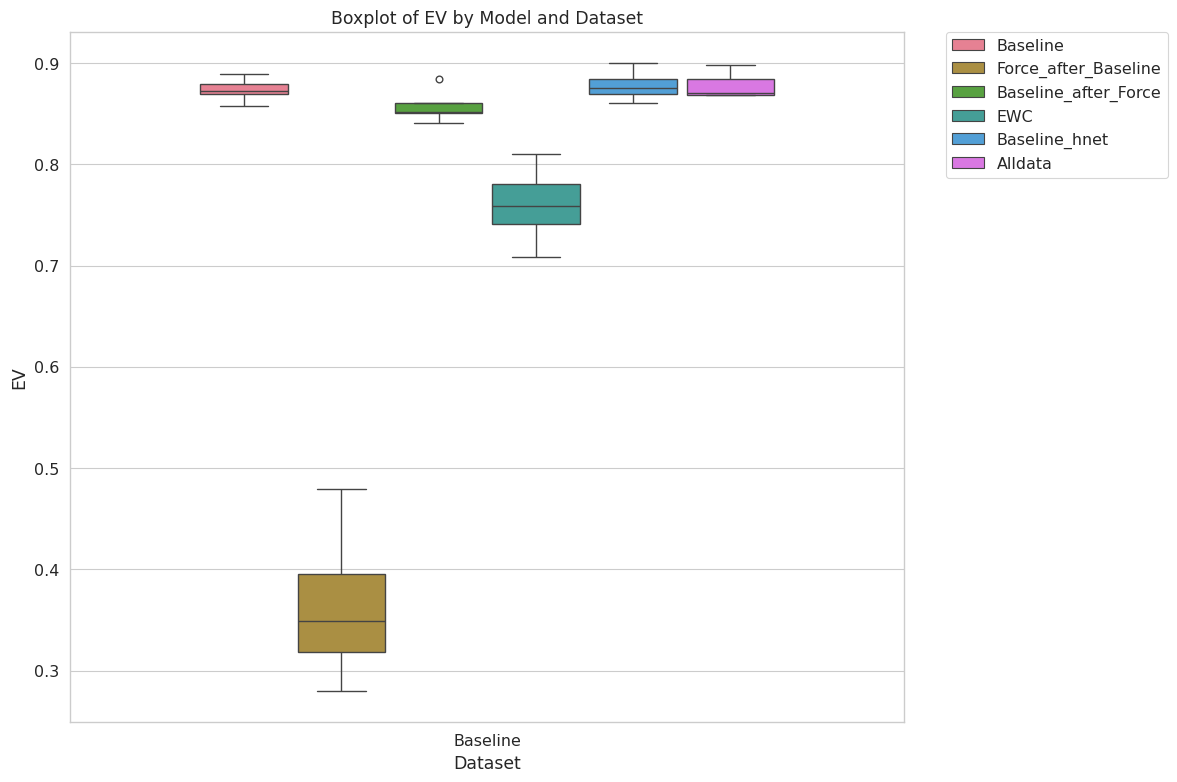

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order of hue categories based on the order of models
hue_order = ['Baseline', 'Force_after_Baseline', 'Baseline_after_Force', 'EWC', 'Baseline_hnet', 'Alldata']

# Define a custom color palette for better differentiation
custom_palette = sns.color_palette("husl", len(hue_order))

# Set style and context for better aesthetics
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.3)

# Create the boxplot
fig = plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.boxplot(x='Dataset', y='EV', hue='Model', data=results_df_baseline,
            hue_order=hue_order, palette=custom_palette, dodge=0.8, width=0.7)

# Adjust legend position
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Add a title and labels
plt.title('Boxplot of EV by Model and Dataset')
#plt.xlabel('Model')
plt.ylabel('EV')

# Show plot
plt.tight_layout()
adjust_box_widths(fig, 0.9)

plt.show()


/tmp/ipykernel_213495/2690038075.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


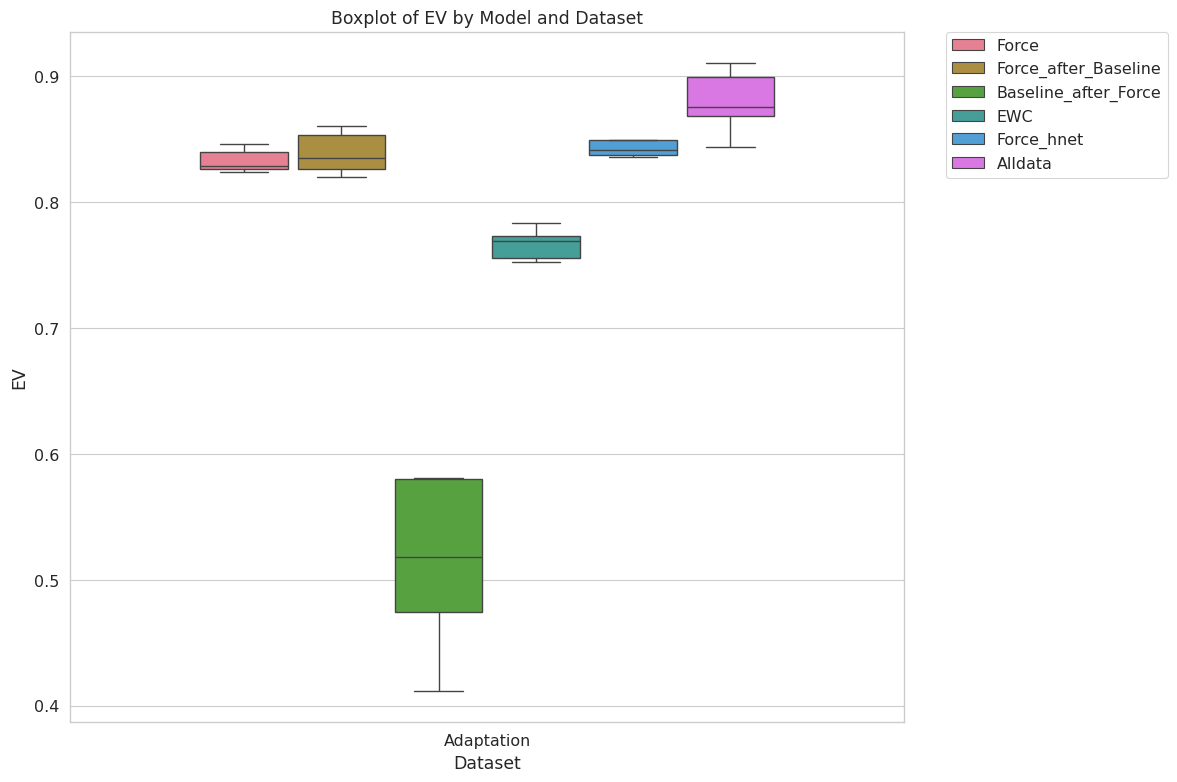

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order of hue categories based on the order of models
hue_order = [ 'Force','Force_after_Baseline',
             'Baseline_after_Force','EWC',
             'Force_hnet', 'Alldata']  # Add other model names in the desired order


# Define a custom color palette for better differentiation
custom_palette = sns.color_palette("husl", len(hue_order))

# Set style and context for better aesthetics
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.3)

# Create the boxplot
fig = plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.boxplot(x='Dataset', y='EV', hue = 'Model', data=results_df_adaptation, hue_order = hue_order, palette=custom_palette, dodge=0.8, width=0.7)

# Adjust legend position
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Add a title and labels
plt.title('Boxplot of EV by Model and Dataset')
#plt.xlabel('Model')
plt.ylabel('EV')

# Show plot
plt.tight_layout()
adjust_box_widths(fig, 0.9)

plt.show()


In [29]:
results_bas_1 = results_df_baseline.loc[results_df_baseline.Fold == 'fold_1'].reset_index()

In [30]:
results_bas_1

,index,Model,Dataset,Fold,EV,R2,Y_pred,Y_true
0,6,Baseline_hnet,Baseline,fold_1,0.899855,0.899061,"[[[2.0509782, 3.1572366], [0.43699956, 1.07937...","[[[0.85819334, 0.9150491], [1.2472336, 0.89152..."
1,21,Alldata,Baseline,fold_1,0.898226,0.897119,"[[[1.2656798, 4.5276113], [0.7282221, 2.483344...","[[[0.85819334, 0.9150491], [1.2472336, 0.89152..."
2,36,EWC,Baseline,fold_1,0.809943,0.808055,"[[[0.8763808, 1.1706231], [1.8358233, 3.409773...","[[[0.85819334, 0.9150491], [1.2472336, 0.89152..."
3,66,Force_after_Baseline,Baseline,fold_1,0.478818,0.473658,"[[[1.2593806, 1.2538391], [1.9323996, 2.719944...","[[[0.85819334, 0.9150491], [1.2472336, 0.89152..."
4,81,Baseline_after_Force,Baseline,fold_1,0.883800,0.883273,"[[[1.1237165, 4.7475905], [0.76750743, 2.35074...","[[[0.85819334, 0.9150491], [1.2472336, 0.89152..."
5,111,Baseline,Baseline,fold_1,0.888754,0.887379,"[[[0.45597076, 1.0318708], [1.0244776, 2.87486...","[[[0.85819334, 0.9150491], [1.2472336, 0.89152..."


In [31]:
len(results_bas_1['Y_pred'][0][0][:100,0])

100

In [32]:
models = results_bas_1.Model.unique()

In [33]:
models =['Baseline_hnet', 'EWC', 'Baseline']

In [34]:
m_data = results_bas_1.loc[results_bas_1.Model == m]
preds = m_data.Y_pred[0][0][:100,0]

KeyError: 0

In [ ]:
preds

array([-4.9523693e-01, -1.1366205e+00, -7.6052237e-01, -2.8876412e-01,
       -3.5689183e-02,  1.3401134e-01,  2.4266724e-01,  2.8251284e-01,
        2.5313166e-01,  1.6977890e-01,  5.4652445e-02, -7.2937764e-02,
       -1.9673641e-01, -3.0747437e-01, -3.9729807e-01, -4.6224460e-01,
       -5.0090826e-01, -5.0947779e-01, -4.8593247e-01, -4.3243140e-01,
       -3.5739532e-01, -2.7310380e-01, -1.9274892e-01, -1.2779205e-01,
       -8.4974773e-02, -6.2844343e-02, -5.0573148e-02, -3.4141578e-02,
       -4.7418266e-03,  3.5804652e-02,  7.3856287e-02,  9.0936653e-02,
        6.8906210e-02, -2.3612170e-03, -1.2461800e-01, -2.8068763e-01,
       -4.4410068e-01, -5.8851057e-01, -6.9497436e-01, -7.5602019e-01,
       -7.7728420e-01, -7.7375144e-01, -7.6703405e-01, -7.8750205e-01,
       -8.5973358e-01, -1.0145047e+00, -1.2794082e+00, -1.7124095e+00,
       -2.4172328e+00, -3.4763567e+00, -5.1044774e+00, -7.2427735e+00,
       -9.6632090e+00, -1.1961119e+01, -1.3738790e+01, -1.4530838e+01,
      

In [ ]:
m_data = results_bas_1.loc[results_bas_1.Model == 'Alldata']
preds = m_data.Y_pred.values

In [ ]:
preds

array([list([array([[ 1.2656798 ,  4.5276113 ],
              [ 0.7282221 ,  2.4833448 ],
              [ 0.569146  ,  0.6166276 ],
              ...,
              [-0.34338638, -0.18541358],
              [-0.54264957, -0.3815403 ],
              [-0.6594823 , -0.3616575 ]], dtype=float32)])], dtype=object)

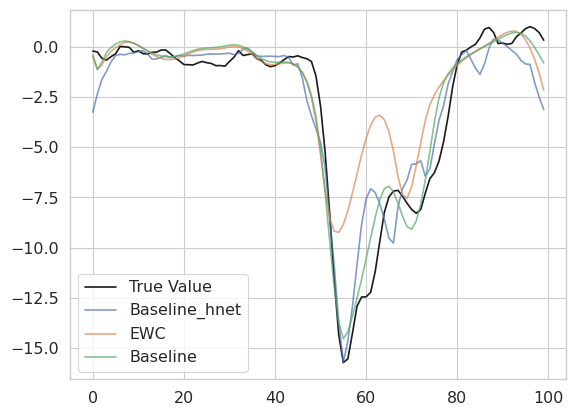

In [ ]:
for i, m in enumerate(models):
     if i == 0 :
          m_data = results_bas_1.loc[results_bas_1.Model == m]['Y_true'].values
          true = m_data[0][0][300:400,0]
          plt.plot(true, color = 'k', label = 'True Value')
     m_data = results_bas_1.loc[results_bas_1.Model == m]['Y_pred'].values
     preds = m_data[0][0][300:400,0]
     plt.plot(preds, label = m, alpha = 0.7)
plt.legend()

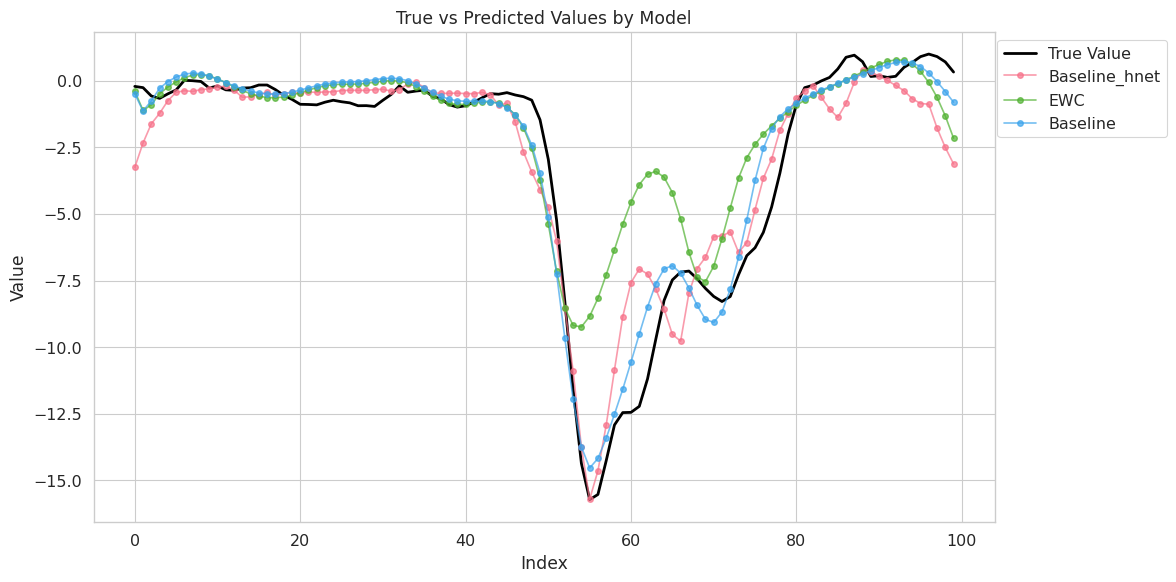

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'results_bas_1' is your DataFrame containing Model, Y_true, and Y_pred columns

# Define a color palette with enough colors for each model
palette = sns.color_palette('husl', n_colors=len(models))

plt.figure(figsize=(12, 6))

for i, m in enumerate(models):
    m_data = results_bas_1.loc[results_bas_1.Model == m]
    true = m_data['Y_true'].values[0][0][300:400, 0]  # Extract true values for plotting
    
    # Plot true values only once
    if i == 0:
        plt.plot(true, color='black', linestyle='-', label='True Value', linewidth=2)
    
    preds = m_data['Y_pred'].values[0][0][300:400, 0]  # Extract predicted values for plotting
    plt.plot(preds, label=m, linestyle='-', marker='o', markersize=4, alpha=0.7, color=palette[i])

# Customize plot
plt.title('True vs Predicted Values by Model')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()


# TO DO: MAKE IT MORE LIKE THE ONE FOR MATHIS LAB, WITH DIFFERENT TRIALS AND OR THE 2 SENSORS. 